# Anomaly Detection

When to use anomaly detection vs. when to use supervised learning:

- **Anomaly detection:**
    - Very few positive examples (y = 1) (0-20 is common), with a large number of negative examples (y = 0).
    - If there are many different "types" of anomalies. It's challenging for any algorithm to learn from positive examples what the anomalies look like; future anomalies may bear no resemblance to any of the anomalous examples encountered thus far.
    - Examples: 
        - Fraud detection.
        - Manufacturing: finding new previously unseen defects in manufacturing.
        - Monitoring machines in a data center (different types of attacks or malfunctions).

- **Supervised learning:**
    - Large number of positive and negative examples.
    - Sufficient positive examples for the algorithm to grasp what positive examples entail; future positive examples are likely to resemble those in the training set.
    - Examples: 
        - Email spam classification.
        - Manufacturing: finding known previously seen defects.
        - Weather prediction (sunny/rainy/etc.).
        - Diseases classification.


## Librarys

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

## Dataset

In [16]:
df = pd.read_csv("data\climate change\GlobalLandTemperaturesByCountry.csv")
print(df.columns)
df.head()

Index(['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'Country'], dtype='object')


,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [17]:
x_train = df[['dt', 'AverageTemperature', 'Country']]

x_train_brazil = x_train['Country'] == 'Brazil'
x_train = x_train[x_train_brazil]
x_train.dropna(inplace=True)
x_train['dt'] = pd.to_datetime(x_train['dt'])
x_train['Month'] = x_train['dt'].dt.month

sample_rows = x_train.sample(n=10)
sample_rows

,dt,AverageTemperature,Country,Month
78688,1963-07-01,23.474,Brazil,7
78401,1939-08-01,24.297,Brazil,8
78254,1927-05-01,23.760,Brazil,5
78559,1952-10-01,25.507,Brazil,10
79247,2010-02-01,26.802,Brazil,2
78396,1939-03-01,25.497,Brazil,3
77836,1892-07-01,22.367,Brazil,7
78008,1906-11-01,25.530,Brazil,11
78907,1981-10-01,25.318,Brazil,10
78344,1934-11-01,25.678,Brazil,11


In [18]:
x_train = x_train[['AverageTemperature', 'Month']]
x_train.head()

,AverageTemperature,Month
77110,24.935,1
77111,24.505,2
77112,24.617,3
77113,23.990,4
77114,23.124,5


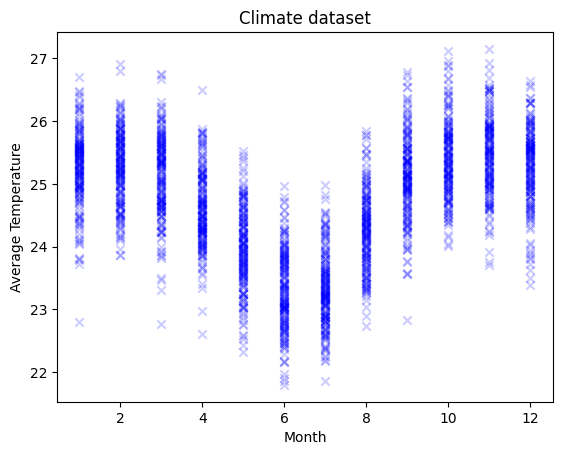

In [19]:
plt.scatter(x_train['Month'], x_train['AverageTemperature'], marker='x', c='b', alpha=0.2) 
plt.title("Climate dataset")
plt.ylabel('Average Temperature')
plt.xlabel('Month')
plt.show()

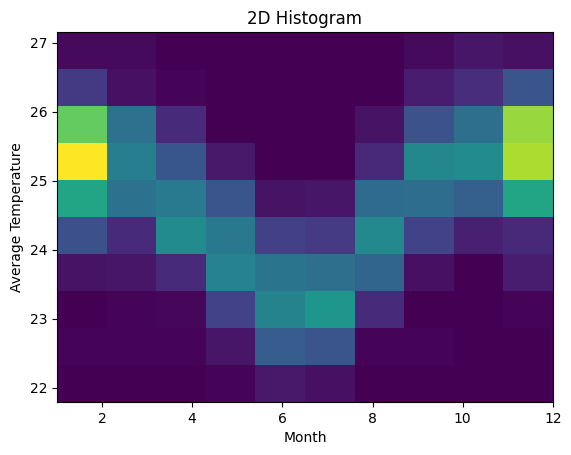

In [20]:
plt.hist2d(x_train['Month'], x_train['AverageTemperature'])
plt.title("2D Histogram")
plt.ylabel('Average Temperature')
plt.xlabel('Month')
plt.show()

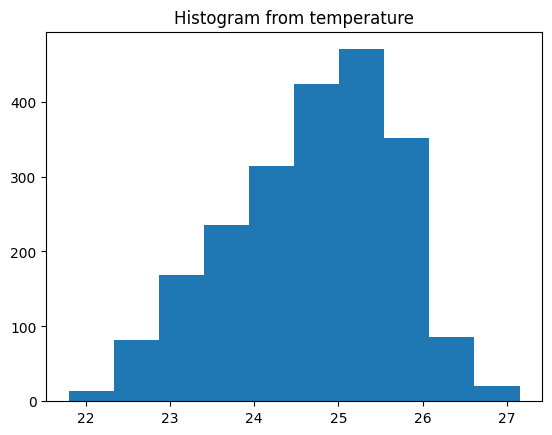

In [21]:
plt.hist(x_train['AverageTemperature'])
plt.title("Histogram from temperature")
plt.show()

## Gaussian distribution

To perform anomaly detection, you will first need to fit a model to the data’s distribution. But first, we need the mean and the variance.

### Mean and variance

To estimate the parameters ($\mu_i$, $\sigma_i^2$) of the $i$-th
feature, we will be using the following equations:

- Mean:
    $$\mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}$$

- Variance:
    $$\sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2$$

In [22]:
def estimate_gaussian(X): 
    """
    Calculates mean and variance of all features 
    in the dataset
    
    Args:
        X (ndarray): (m, n) Data matrix
    
    Returns:
        mu (ndarray): (n,) Mean of all features
        var (ndarray): (n,) Variance of all features
    """

    m, n = X.shape
    
    mu = np.sum(X, axis=0) / m
    var = np.sum((X - mu) ** 2, axis=0) / m
    
    return mu, var

In [23]:
# def feature_normalize(dataset):
#     mu = np.mean(dataset, axis=0)
#     sigma = np.std(dataset, axis=0)
#     return (dataset - mu) / sigma

# #define the parameter and estimate the Gaussian distribution
# def estimate_gaussian(dataset):
#     mu = np.mean(dataset, axis=0)
#     sigma = np.var(dataset)
#     return mu, sigma

# #define the multivariate Gaussian distribution
# def multivariate_gaussian(dataset, mu, sigma):
#     p = multivariate_normal(mean=mu, cov=sigma)
#     return p.pdf(dataset)

### Probability Model

* Given a training set $\{x^{(1)}, ..., x^{(m)}\}$ you want to estimate the Gaussian distribution for each of the features $x_i$. 

* The Gaussian distribution is given by

   $$ p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$

   where $\mu$ is the mean and $\sigma^2$ is the variance.
   
* For each feature $i = 1\ldots n$, you need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i$-th dimension $\{x_i^{(1)}, ..., x_i^{(m)}\}$ (the $i$-th dimension of each example).

In [24]:
def multivariate_gaussian(X, mu, var):
    n = len(mu)
    constant = 1 / ((2 * np.pi) ** (n / 2) * np.sqrt(np.prod(var)))
    exponent = -0.5 * np.sum(((X - mu) ** 2) / var, axis=1)
    p = constant * np.exp(exponent)
    
    return p

In [25]:
mu, var = estimate_gaussian(x_train)
print(mu)
print(var)

AverageTemperature    24.699256
Month                  6.486137
dtype: float64
AverageTemperature     0.957582
Month                 11.899531
dtype: float64


In [26]:
# Probabilities
p_val_train = multivariate_gaussian(x_train, mu, var)
p_val_train

### Selecting the threshold $\epsilon$

Now it is possible to investigate which examples have a very high probability given this distribution and which examples have a very low probability.  

* The low probability examples are more likely to be the anomalies in our dataset. 
* One way to determine which examples are anomalies is to select a threshold based on a cross validation set. 

* For this, we will use a cross validation set
$\{(x_{\rm cv}^{(1)}, y_{\rm cv}^{(1)}),\ldots, (x_{\rm cv}^{(m_{\rm cv})}, y_{\rm cv}^{(m_{\rm cv})})\}$, where the label $y=1$ corresponds to an anomalous example, and $y=0$ corresponds to a normal example. 
* For each cross validation example, we will compute $p(x_{\rm cv}^{(i)})$. The vector of all of these probabilities $p(x_{\rm cv}^{(1)}), \ldots, p(x_{\rm cv}^{(m_{\rm cv})})$ is passed to `select_threshold` in the vector `p_val`. 
* The corresponding labels $y_{\rm cv}^{(1)}, \ldots, y_{\rm cv}^{(m_{\rm cv})}$ are passed to the same function in the vector `y_val`.

To implement code to calculate the F1 score from choosing `epsilon` as the threshold and place the value in `F1`. 

  * Recall that if an example $x$ has a low probability $p(x) < \varepsilon$, then it is classified as an anomaly. 
        
  * Then, you can compute precision and recall by: 
      
    $$
    \begin{aligned}
    prec&=&\frac{tp}{tp+fp}\\
    rec&=&\frac{tp}{tp+fn},
    \end{aligned}
    $$ 
    
    where:
      * $tp$ is the number of true positives: the ground truth label says it’s an anomaly and our algorithm correctly classified it as an anomaly.
      * $fp$ is the number of false positives: the ground truth label says it’s not an anomaly, but our algorithm incorrectly classified it as an anomaly.
      * $fn$ is the number of false negatives: the ground truth label says it’s an anomaly, but our algorithm incorrectly classified it as not being anomalous.

  * The $F_1$ score is computed using precision ($prec$) and recall ($rec$) as follows:
    $$F_1 = \frac{2\cdot prec \cdot rec}{prec + rec}$$ 

In [27]:
def select_threshold(y_val, p_val): 
    """
    Finds the best threshold to use for selecting outliers 
    based on the results from a validation set (p_val) 
    and the ground truth (y_val)
    
    Args:
        y_val (ndarray): Ground truth on validation set
        p_val (ndarray): Results on validation set
        
    Returns:
        epsilon (float): Threshold chosen 
        F1 (float):      F1 score by choosing epsilon as threshold
    """ 

    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(p_val) - min(p_val)) / 1000
    
    for epsilon in np.arange(min(p_val), max(p_val), step_size):
    
        predictions = (p_val < epsilon)
        
        tp = sum((predictions == 1) & (y_val == 1))
        fp = sum((predictions == 1) & (y_val == 0))
        tn = sum((predictions == 0) & (y_val == 0))
        fn = sum((predictions == 0) & (y_val == 1))
        
        prec = tp / (tp + fp)        
        rec = tp / (tp + fn)
        
        F1 = 2 * prec * rec / (prec + rec)
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1

In [69]:
size_val = 100
max_temp = max(x_train['AverageTemperature'])
min_temp = min(x_train['AverageTemperature'])
x_val = [
    [
        random.randint(1, 12),
        random.uniform(max_temp, max_temp+10)
    ] for _ in range(size_val//2)
]

[x_val.append(
    [
        random.randint(1, 12),
        random.uniform(min_temp-10, min_temp)
    ] 
) for _ in range(size_val//2)]

y_val = [1 for _ in range(size_val)]

x_val

[[9, 30.11581462007033],
 [9, 31.1155811563087],
 [6, 28.483217088480238],
 [5, 34.112706523703125],
 [5, 33.59585044334058],
 [7, 33.928871892353044],
 [3, 32.55957276986742],
 [11, 28.767224441142428],
 [5, 32.81344649738083],
 [7, 33.574192334421284],
 [11, 31.622945059305884],
 [11, 28.615900965567494],
 [1, 29.55839982660373],
 [6, 36.808187017739286],
 [9, 28.523974596667404],
 [5, 29.692357512432334],
 [2, 28.304094617867946],
 [11, 31.027544111866597],
 [12, 33.55182708912565],
 [2, 32.84163977327596],
 [11, 28.99615992617323],
 [1, 32.71764978988017],
 [3, 35.09188443427378],
 [1, 36.709670020070476],
 [1, 29.195958092717337],
 [4, 32.51133596096749],
 [9, 35.03311724028602],
 [8, 28.68187646598829],
 [5, 33.47569439481892],
 [5, 36.60048851140667],
 [2, 28.497132040226035],
 [12, 30.672559171409453],
 [12, 29.60305029002226],
 [5, 31.836401392081655],
 [2, 30.328751628686636],
 [5, 33.21678117280336],
 [3, 35.09641779342617],
 [10, 34.47299734052524],
 [9, 32.05861986599747],

In [66]:
p_val = multivariate_gaussian(x_val, mu, var)
epsilon, F1 = select_threshold(y_val, p_val)

print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set: %f' % F1)


ValueError: Length of values (100) does not match length of index (2)